<a href="https://colab.research.google.com/github/Syed-Ali-Hussain/SAM-image-detection/blob/main/RemoteSensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

#***Segmenting remote sensing image data using SAM***

---





#Introduction
The Segment Anything Model (SAM) is a state-of-the-art model for generating masks for image segmentation. This report focuses on evaluating the performance of SAM by calculating the Partial Cross-Entropy Loss (PCEL) between the predicted masks and ground truth (GT) masks. We explore the impact of two factors — alpha (𝛼) and gamma (𝛾) — on the PCEL and subsequently on the segmentation performance.

$$ \alpha : \ \ \text{a balancing factor for the importance of positive samples.}
$$
$$
\gamma : \ \ \text{a focusing parameter to reduce the loss for well-classified examples.}
$$

##Partial Cross Entropy Loss

###Focal Loss formula:
$$
\text{FL}(p_{t}) = -\alpha_t (1 - p_{t})^\gamma \log\left(p_{t}\right)
$$


$$
p_t =
\begin{cases}
p_i & \text{if } y_i = 1 \\
1 - p_i & \text{if } y_i = 0
\end{cases}
$$

where
$$
p_i \hspace{0.5 cm}\ \text{is the predicted probability of the pixel being foreground}
$$
$$
y_i \hspace{0.5 cm}\ \text{is the ground truth label for the pixel. 1 for the foreground}
$$


source: https://medium.com/swlh/focal-loss-what-why-and-how-df6735f26616

###Partial Cross Entropy Loss formula:

$$
pfCE = \frac{\sum(Focal Loss(predicted, GT) \times Mask_{labeled})}{\sum Mask_{labeled}}
$$


where

$$
Mask_{labeled} \hspace{0.5 cm}\ \text{is ground truth pixel's binary mask value}
$$
$$
$$
$$
Mask_{labeled} =
\begin{cases}
0 & \text{if pixel is background in GT mask} \\
1 & \text{if pixel is foreground in GT mask}
\end{cases}
$$

## Purpose and Hypothesis
**The purpose of this experiment is to explore the accuracy of SAM and can be further used to inspect the impact of the alpha (𝛼) and gamma (𝛾) parameters on the performance of SAM.**


##Experimental Process
Data Preparation: Collect a set of images and corresponding ground truth masks for evaluation.

Model Prediction: Use SAM to generate predicted masks for each image.

Parameter Exploration: Evaluate PCEL for a range of 𝛼 and 𝛾 values

Performance Evaluation: Calculate the average PCEL for each combination of 𝛼 and 𝛾.

#The Code

In [1]:
# GT image subject colors:
red = 0
green = 255
blue = 0
# set accordingly

##Importing libraries and SAM

In [3]:
import cv2
import sys
import torch
import torchvision
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

##Make sure to provide the path to your images


1.   The source image to identify objects from
2.   A ground truth mask for the image, to calculate the loss


In [5]:
image = cv2.imread("/content/96870_sat.jpg") # satellite image
GT_image_path = "/content/96870_mask.png"    # Ground truth mask image

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

##Displaying the source image and predicting the mask

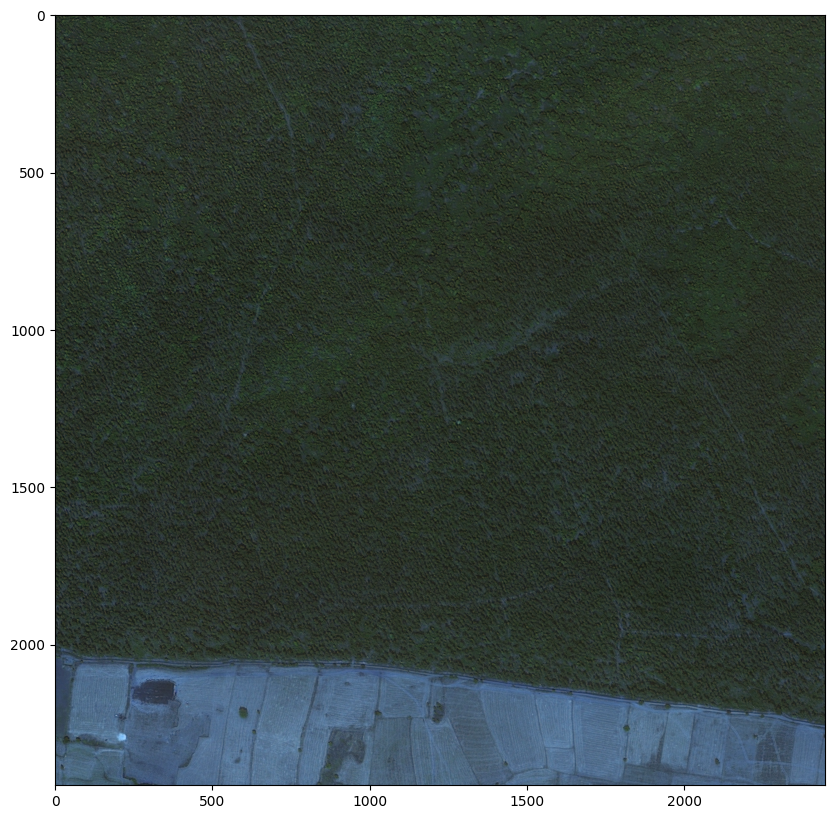

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [8]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
predictor.set_image(image)

In [10]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

In [11]:
input_box = [0, 0, 2446, 2446]  # [x0, y0, x1, y1]

###You can either specify a point on the target object or draw a box around it.

Our object occupies too much space so a point will be a better option

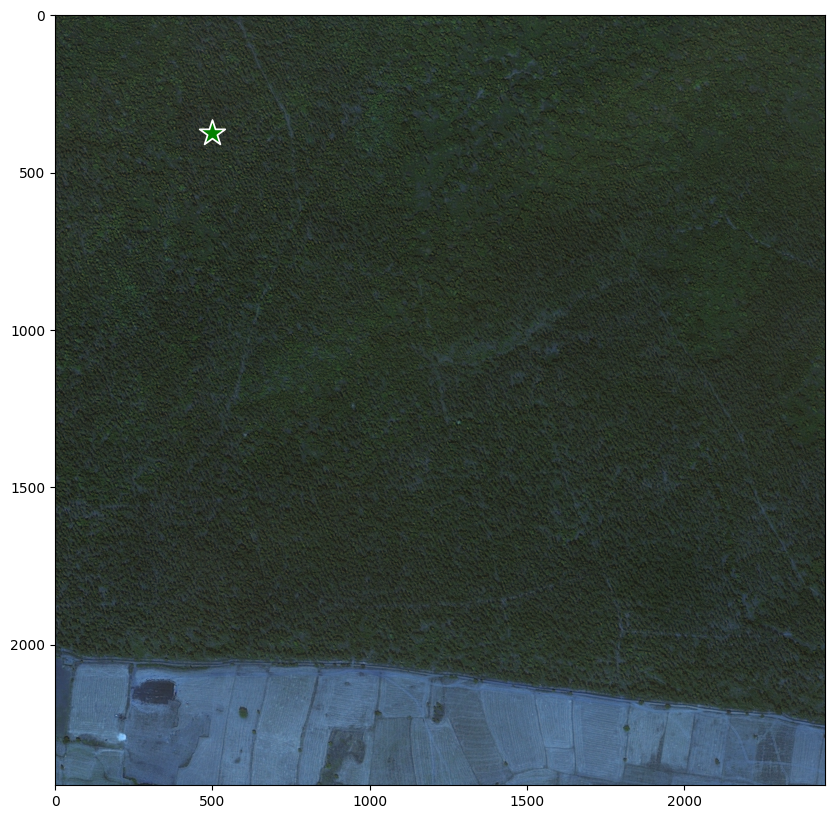

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
# show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [13]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [14]:
masks.shape  # (number_of_masks) x H x W

(3, 2448, 2448)

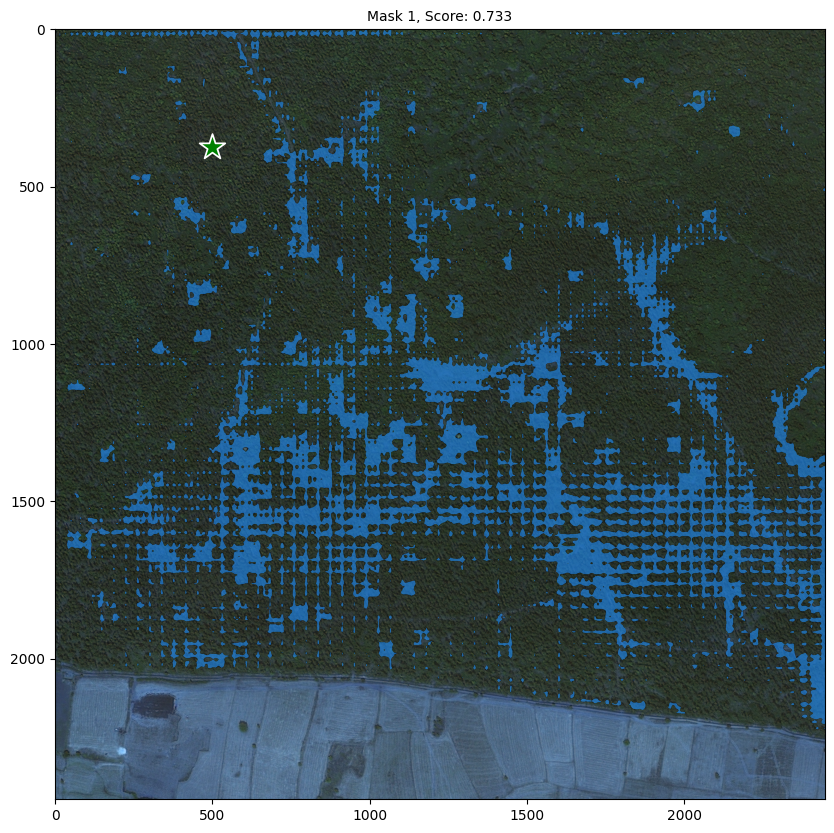

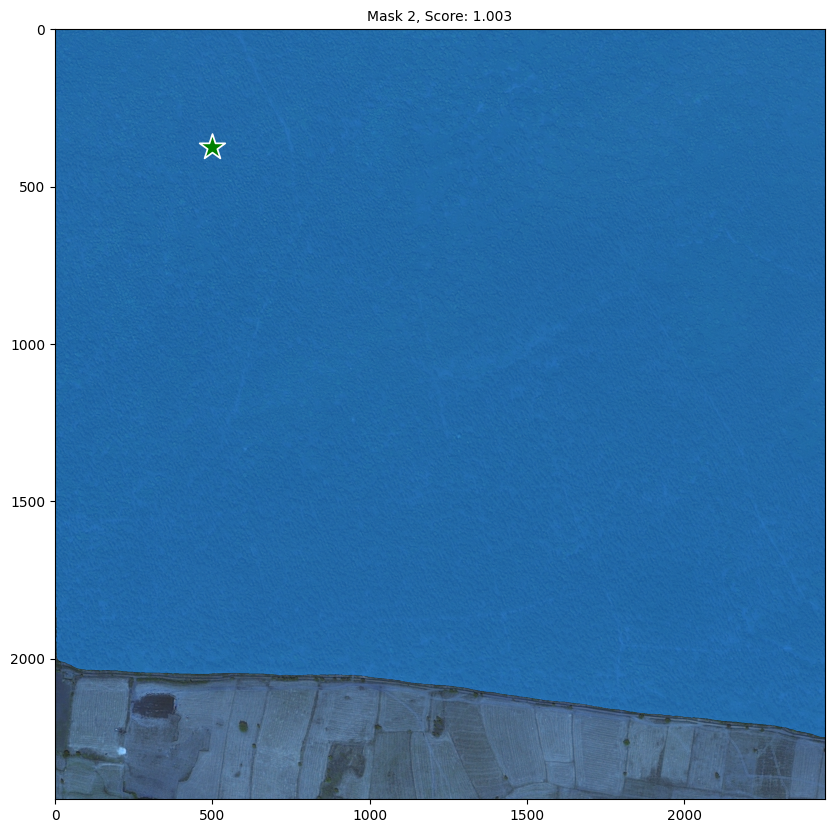

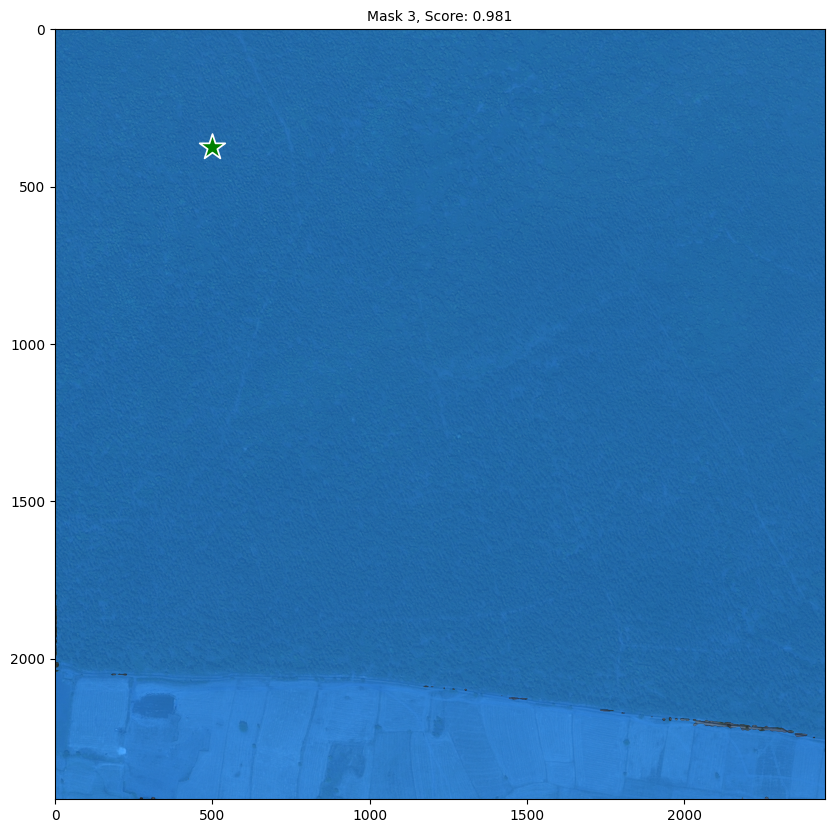

In [15]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=10)
    plt.axis('on')
    plt.show()

##Labeling

Select the mask that is most relevant for the task

Or simply the highest score

In [16]:
logit = logits[1] # taking only logits of mask 2

In [17]:
logits_tensor = torch.from_numpy(logit)

In [ ]:
# Convert logits to probabilities using sigmoid function
probs = torch.sigmoid(logits_tensor)

# Apply a threshold to get binary mask
threshold = 0.5
binary_mask = (probs > threshold).float()

# Create labels from the binary mask
labels = binary_mask.long()

# Print results
print("Logits:\n", logit)
print("Probabilities:\n", probs)
print("Binary Mask:\n", binary_mask)
print("Labels:\n", labels)

###Heat map representing the probability for each pixel being a part of foreground (forest/tree)

<Axes: >

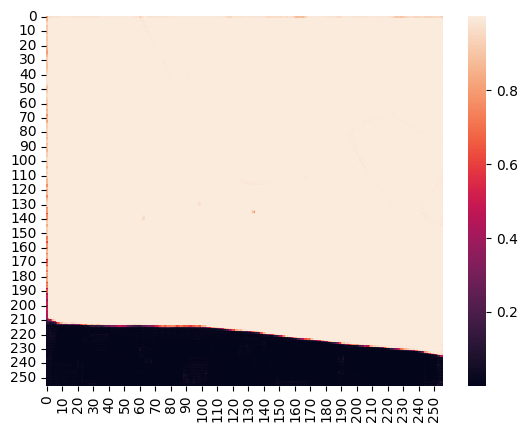

In [19]:
sns.heatmap(probs)

#Ground-Truth mask

In [20]:
imageGT = Image.open(GT_image_path)

In [21]:
image_np = np.array(imageGT)

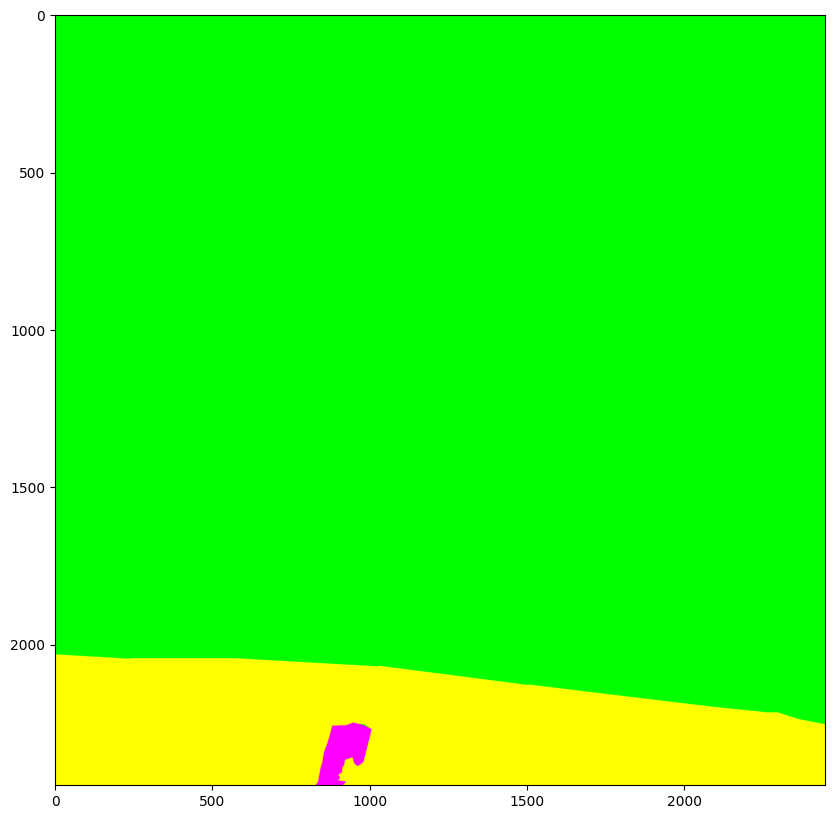

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(imageGT)
plt.axis('on')
plt.show()

In [23]:
# Create a binary mask where green color (0, 255, 0) is set to 1, else 0
green_mask = (image_np[:, :, 0] == red) & (image_np[:, :, 1] == green) & (image_np[:, :, 2] == blue)
binary_maskGT = green_mask.astype(np.uint8)

In [24]:
# Convert the binary mask to a tensor
binary_mask_GT_tensor = torch.tensor(binary_maskGT, dtype=torch.float32)

##Adjusting the dimensions

###The dimensions of the final layer from the SAM are not equivalent to our source image and mask.



*   We can either upscale the logits to match the source mask
*   Or downscale the mask to match the logits

We will be upscaling the logits so we do not lose any information from our Ground truth mask.



In [25]:
# Add a batch dimension and channel dimension to probs
probs = probs.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 256, 256)

In [26]:
# Rescale probs to match the size of binary_maskGT
probs_rescaled = F.interpolate(probs, size=(2448, 2448), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)  # Shape: (2448, 2448)

In [27]:
#p_t = probs_rescaled * binary_maskGT + (1 - probs_rescaled) * (1 - binary_maskGT)

##Loss Function

In [28]:
def focal_loss(alpha, gamma, probability, GT_mask):
  pt = probability * GT_mask + (1 - probability) * (1 - GT_mask)
  loss = -alpha * (1-pt)**gamma * torch.log(pt)
  return loss

In [29]:
def Partial_cross_entropy_loss(alpha, gamma, probability, GT_mask):
  # calculating p_t
  pt = probability * GT_mask + (1 - probability) * (1 - GT_mask)
  # calculating Focal Loss
  loss = -alpha * (1-pt)**gamma * torch.log(pt)

  # calculating patial cross entropy loss
  numerator = (loss * GT_mask).sum()
  denomirator = GT_mask.sum()
  PCEL = numerator/denomirator
  return PCEL

In [30]:
alpha = 1
gamma = 2

In [31]:
Partial_cross_entropy_loss(alpha, gamma, probs_rescaled, binary_mask_GT_tensor)

tensor(0.0015)

##Future Work

This process can be repeated for various values of alpha, gamma and training / fine-tuning SAM in order to observe the improvements within it's prediction.

Comparative Analysis: Compare PCEL with other loss functions like Dice Loss and IoU Loss for a comprehensive evaluation.

##Improvements:


###Issues:






1.   The Loss function PCEL that is being used does not provide a good measure for the regions outside the foreground.

2.   If the mask displayed by the model covers the entire image as foreground the model's error will not be counted.

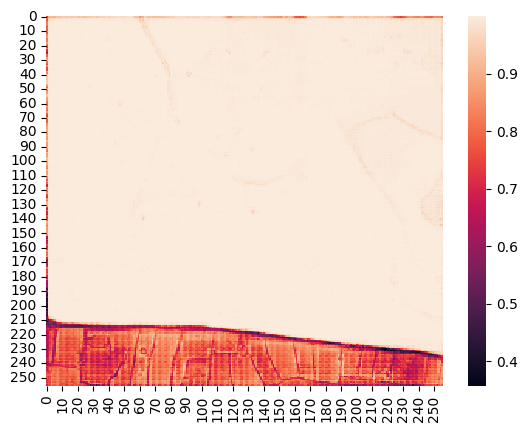

In [38]:
logit = logits[2] # taking only logits of mask 3, covering the whole image
logits_tensor = torch.from_numpy(logit)

# Convert logits to probabilities using sigmoid function
probs = torch.sigmoid(logits_tensor)

# Apply a threshold to get binary mask
threshold = 0.5
binary_mask = (probs > threshold).float()

# Create labels from the binary mask
labels = binary_mask.long()

# displaying the map
sns.heatmap(probs)

# Add a batch dimension and channel dimension to probs
probs = probs.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 256, 256)

# Rescale probs to match the size of binary_maskGT
probs_rescaled = F.interpolate(probs, size=(2448, 2448), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)  # Shape: (2448, 2448)

In [35]:
Partial_cross_entropy_loss(alpha, gamma, probs_rescaled, binary_mask_GT_tensor)

tensor(0.0003)

###As we see the loss has been reduced when the mask is over the entire image.

Even though the lower 20% of the source image is not a part of the forest and has been falsly predicted by SAM as foregroud with probability as above 0.6.

This should ideally have increased the loss value however we see a reduction from the previous case.


###Solution:

We need a loss function that not only calculates the error within the foreground but also considers the background